# Model calibration

## Overview

This notebook provides an overview of how to calibrate the UK labour market model. 

Throughout the notebook, we use the acronyms SIC for "Standard Industrial Classification", SOC for "Standard Occupational Classification", and LFN for "labour flow network".

## Import packages

In [1]:
import numpy as np
import pandas as pd
import pickle
import itertools
import time
import os
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import ast

## Set variables related to file names/locations

In [2]:
# Set working directory
home =  os.getcwd()[:-4]

# Choose the variables of interest
regvar = "GORWKR" #geographical region 
sicvar = "Inds07m" #industry (SIC)
socvar = "SC10MMJ" #occupation (SOC)

## Define all required functions

In [3]:
def normalized_transitions(matrix):
    
    """Normalize transition matrix
    
        Inputs:
            matrix = the matrix the user wishes to normalize

        Outputs:
            matrix_temp = matrix containing normalized values
    """
    
    matrix_temp = matrix.copy()   
    matrix_temp = matrix_temp/matrix_temp.sum().sum() #Normalize by dividing all cells by largest cell
    
    return matrix_temp

def gd_sim(i):
    
    """Run a simulation and return information on final timestep unemployment and labour flow networks (LFNs)
    
    
        Inputs:
            i = indicidates the current realisation of the model
            
        Outputs:
            gd_result = tuple containing information on the unemployment rate and LFNs at the final timestep of the simulation
            
    """
    # Run a simulation
    model_output = sim.extended_run_simulation(input_data_dict_temp)
    # Unpack simulation output
    wor_ids,wor_jobs,wor_job_node_ids,wor_ages,wor_consumption_prefs, \
                    wor_wages,wor_nonlabour_incomes, \
                    wor_unemp_spells,wor_employmentstatus, \
                    pos_ids,pos_node_ids,pos_status,pos_worker_ids, \
                    pos_reg,pos_sic,pos_soc,pos_wages, \
                    statoff_u_rates,statoff_u_durations,statoff_jtj_moves, \
                    statoff_num_vacancies,statoff_reg_transition_matrix, \
                    statoff_sic_transition_matrix,statoff_soc_transition_matrix, \
                    statoff_obj_vals,statoff_active_searches = model_output
    
    # Normalize simulated transition matrices
    sim_reg_tmat = normalized_transitions(statoff_reg_transition_matrix)
    sim_sic_tmat = normalized_transitions(statoff_sic_transition_matrix)
    sim_soc_tmat = normalized_transitions(statoff_soc_transition_matrix) 
    
    gd_result = np.mean(statoff_u_rates[-avg_length_urates:]), sim_reg_tmat, \
        sim_sic_tmat, sim_soc_tmat, statoff_reg_transition_matrix, \
        statoff_sic_transition_matrix, statoff_soc_transition_matrix                
                    
    # Return unemployment rate and LFNs at final timestep
    return gd_result

## Read in all input files, and set all necessary parameters

In [4]:
### Populate data dictionary for input into simulation function

file = open(f'{home}data/20220520 KF PrePub 2001646/activation_dict.txt', "r")
contents = file.read()
adict = ast.literal_eval(contents)
file.close()

file = open(f'{home}data/20220520 KF PrePub 2001646/income_dict_LFS_{regvar}_{sicvar}_{socvar}.txt', "r")
contents = file.read()
idict = ast.literal_eval(contents)
file.close()
   
# Global parameters
N = 3500 # number of workers in the model
# Vacancy rate for initializing the number of positions
num_vac = 800000
num_jobs = 36000000
vacancy_rate = num_vac/num_jobs
P = int(N*(1+vacancy_rate)) # number of positions in the model
granularity = 1 # Granularity for timestep (1 = yearly, 12 = monthly, 52 = weekly, etc.)
job_destruction_rate = 0.0463 # ratio of positions randomly destroyed in 1 iteration (Value from Aron's calibration)
job_creation_rate = job_destruction_rate # ratio of positions randomly created in 1 iteration
PD = int(job_destruction_rate*P) # Get the number of positions to be destroyed
PC = int(job_creation_rate*P) # Get the number of positions to be created
new_worker_init_age = 18 # Intial age of newly created workers
## Survival rates
# Read-in survival rate data from ONS National Life Tables (weighted mean across male and female rates, 2017-2019)
survival_dat = pd.read_excel(f'{home}data/nationallifetable_20172019_wmeans.xlsx')
# Convert to numpy array for computational efficiency
worker_survival_rates = np.asarray(survival_dat.mean_survival)
activation_rate_unemployed = adict['activation_dict']['unemployed_active_weight']/adict['activation_dict']['unemployed_weight'] #0.7923 #Rate at which unemployed workers are activated to perform a job search (set based roughly on 1 - mean economic inactivity rate for 2019, taken from https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/bulletins/employmentintheuk/april2021)
activation_rate_employed = adict['activation_dict']['employed_active_weight']/adict['activation_dict']['employed_weight'] #Ratio controlling the relative frequency with which employed workers are actively searching (as compared to the unemployed) 
sample_size = 1 # Number of candidate positions each active worker will sample within a timestep
gamma = 0.9662 # discount factor for utility calculations
#Global min/max income for generating wages
wage_max = idict['income_dict']['max_annincome']
wage_min = idict['income_dict']['min_annincome']
if wage_min==0:
    wage_min = 0.01
    
#Steady state convergence parameters
ss_threshold = 0.0001 # threshold for convergence to steady state
lag = 50 # Lag value for performing convergence calculation
avg_length = 25 # Breadth of window to average over when performing convergence calculation
avg_length_urates = avg_length # Breadth of window to average over when calculating steady-state unemployment rate
t_ss=0 # Dummy value for the time for the initial flows to stabilise (leave set to 0)

### Read in empirical transition matrices. convert to numpy arrays
reg_trans_mat = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/region_transitiondensity_empirical_LFS_{regvar}_{sicvar}_{socvar}.csv', 'rb'), header=0,index_col=0)
sic_trans_mat = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/sic_transitiondensities_empirical_LFS_{regvar}_{sicvar}_{socvar}.csv', 'rb'), header=0,index_col=0)
soc_trans_mat = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/soc_transitiondensities_empirical_LFS_{regvar}_{sicvar}_{socvar}.csv', 'rb'), header=0,index_col=0)


reg_trans_mat = reg_trans_mat.to_numpy()
sic_trans_mat = sic_trans_mat.to_numpy()
soc_trans_mat = soc_trans_mat.to_numpy()

### Generate category labels for region, SIC, SOC
reg = np.arange(1,reg_trans_mat.shape[0]+1) # Regional category labels
sic = np.arange(1,sic_trans_mat.shape[0]+1) # SIC category labels
soc = np.arange(1,soc_trans_mat.shape[0]+1) # SOC category labels

# Create list of arrays containing all possible values of the integers associated with the regions, SIC sections, and 1-digit SOC codes
iterables = [reg, sic, soc]

# Generate all possible combinations of these (region, SIC, SOC) integers (each corresponding to a potential node)
combos = list(itertools.product(*iterables))

# Create dictionary of (region, SIC, SOC) IDs for these nodes, with associated integer index values
node_dict = {}
for i in range(0,len(combos)):
    node_dict[i] = combos[i] #Key is the numeric index, value is the (reg, sic, soc) triplet
    
n = len(node_dict) #Total number of nodes

# Read in similarity matrices
node_reg_sim_mat = pickle.load(open(f'{home}data/reg_expanded_similaritymat_LFS.sav', 'rb')) # Region (geographical) similarity
node_sic_sim_mat = pickle.load(open(f'{home}data/sic_expanded_similaritymat_LFS.sav', 'rb')) # SIC (industry) similarity
node_soc_sim_mat = pickle.load(open(f'{home}data/soc_expanded_similaritymat_LFS.sav', 'rb')) # SOC (occupation) similarity

# Get the number of distinct categories for each of region, sic, soc
num_reg = len(reg)
num_sic = len(sic)
num_soc = len(soc)

### Read in simplfied (region, sic division, 1-digit soc) distribution
pos_dist = pd.read_csv(open(f'{home}data/positiondist_reweighted_LFS_{regvar}_{sicvar}_{socvar}.csv'))

### Read in income data for generating wages
inc_dist = pd.read_csv(open(f'{home}data/20220520 KF PrePub 2001646/incomedist_LFS_{regvar}_{sicvar}_{socvar}.csv'))

### Read in age distribution
age_dist = pd.read_csv(open(f'{home}data/age_dist_reweighted_LFS_{regvar}_{sicvar}_{socvar}.csv'), dtype="float64")['AGE']

### Read in consumption preference distribution
cpr_dist = pd.read_csv(open(f'{home}data/consumptionpref_dist_reweighted_LFS_{regvar}_{sicvar}_{socvar}.csv'))['consumption_pref']

### Populate data dictionary for input into simulation function
with open('%sdata/build_dict_LFS_v1.txt' % home, 'r') as file:
    data = file.read()    
exec(data)

# Create temporary copy of the input data dictionary to be modified during the simulations
input_data_dict_temp = copy.deepcopy(input_data_dict)

## Set up calibration

In [5]:
### Import simulation functions
import ABMrun_LFS_cleaned as sim

# Set gradient descent calibration parameters
fitrun_num = 1 # Number of times to run calibration algorithm
sim_num = 15 #number of simulations per iteration of calibration algorithm
alg_thresh = 0.001 #Threshold at which we stop running the fitting algorithm

## Run calibration

Region - frob
[0.20093180439752428]
Region - pearson
[0.6100311498493927]
Industry - frob
[0.08882300715672259]
Industry - pearson
[0.8992981030897054]
Occupation - frob
[0.19622268653245833]
Occupation - pearson
[0.6665478905033076]
Comb - frob
[0.16199249936223506]
Comb - pearson
[0.7252923811474685]
Absolute error metric: 0.005781428068652191


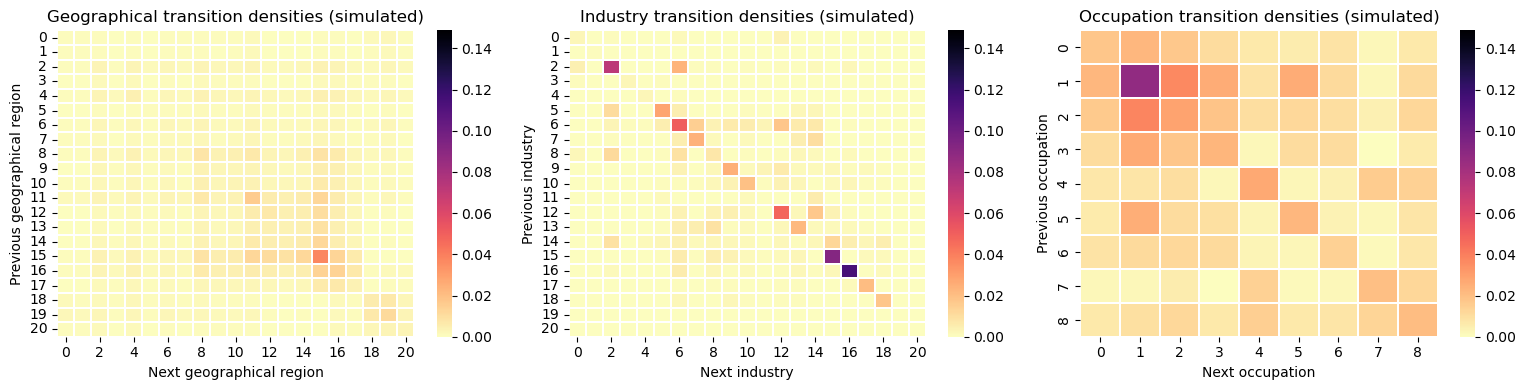

End of iteration 1
Region - frob
[0.19134709907208297]
Region - pearson
[0.6870875153568229]
Industry - frob
[0.07268355255910784]
Industry - pearson
[0.935287373944467]
Occupation - frob
[0.18814335459617967]
Occupation - pearson
[0.7031142435719735]
Comb - frob
[0.15072466874245682]
Comb - pearson
[0.7751630442910878]
Absolute error metric: 0.005354195003576265


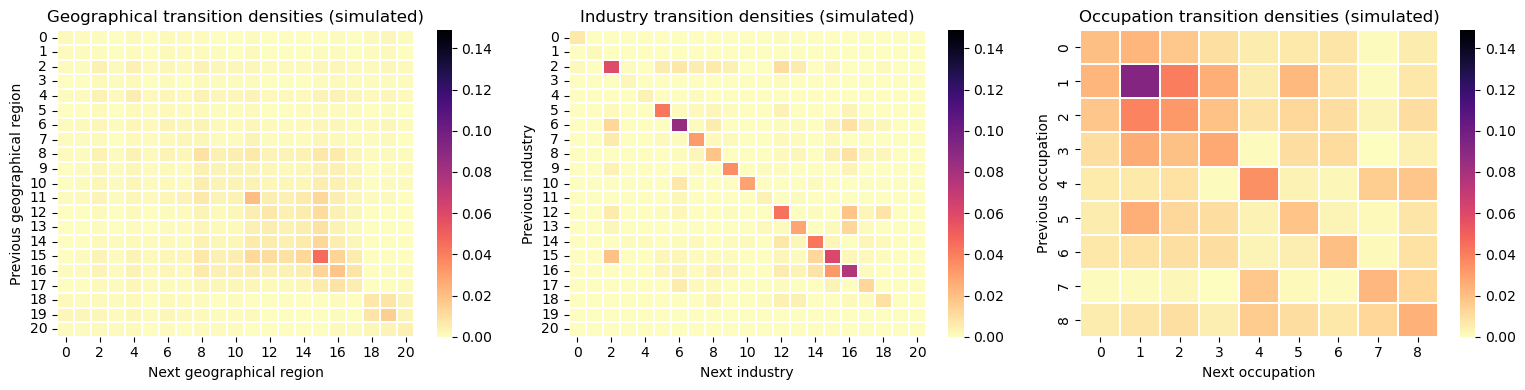

End of iteration 2
Region - frob
[0.18018804012656545]
Region - pearson
[0.746675835167308]
Industry - frob
[0.06515135721423627]
Industry - pearson
[0.9474762054478796]
Occupation - frob
[0.17841050988512536]
Occupation - pearson
[0.7385667218737014]
Comb - frob
[0.141249969075309]
Comb - pearson
[0.8109062541629629]
Absolute error metric: 0.005015771831139965


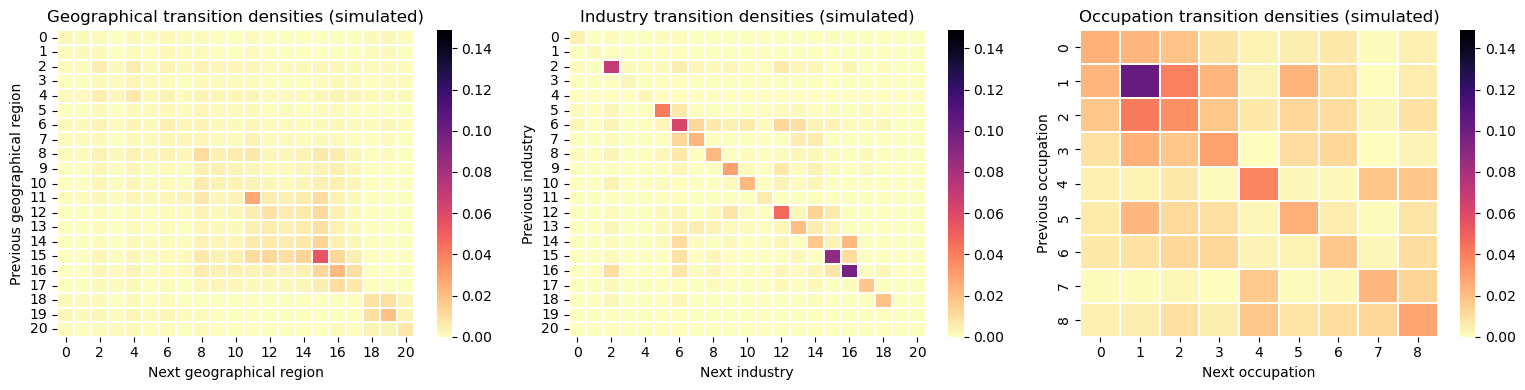

End of iteration 3


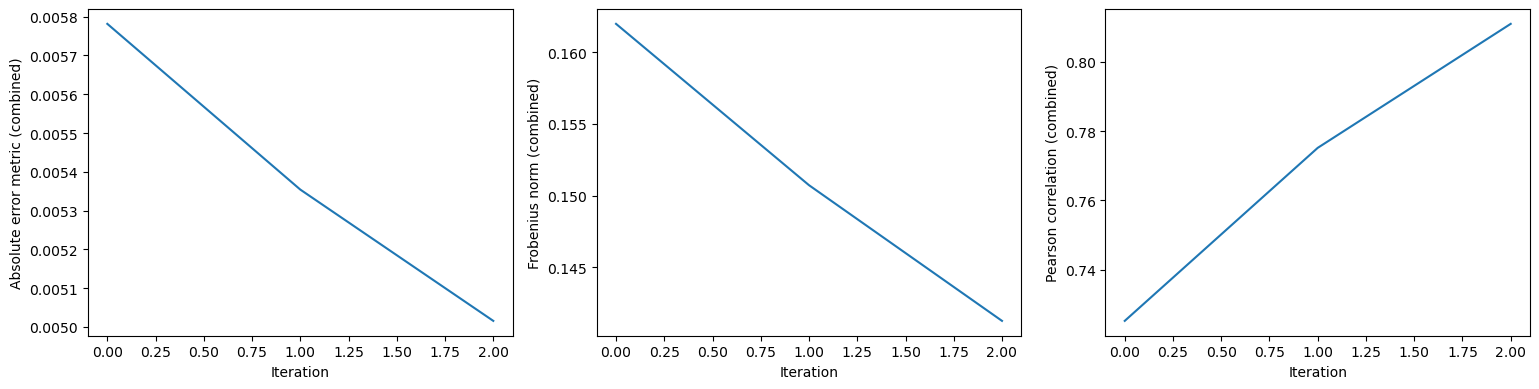

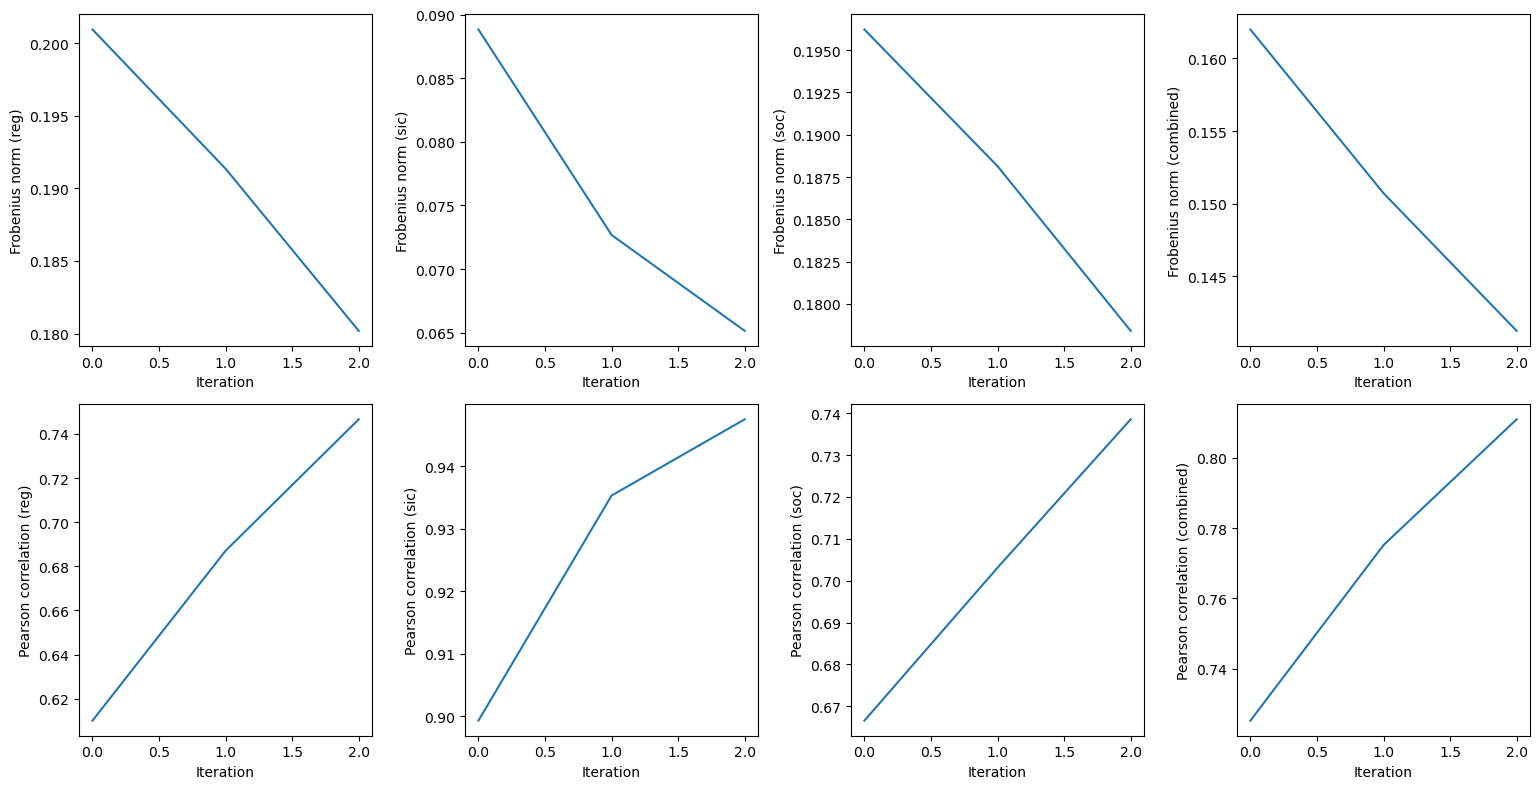

Region - frob
[0.16228019211390837]
Region - pearson
[0.8142370140993397]
Industry - frob
[0.05503240841849442]
Industry - pearson
[0.9624276284448188]
Occupation - frob
[0.16381901192381723]
Occupation - pearson
[0.7877925753255043]
Comb - frob
[0.12704387081874]
Comb - pearson
[0.8548190726232209]
Absolute error metric: 0.004421823081982798


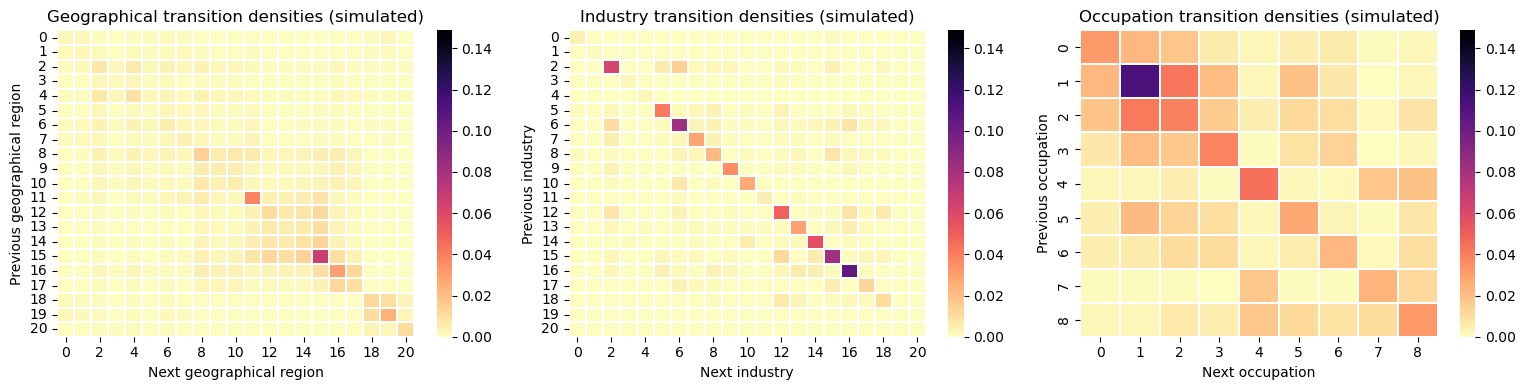

End of iteration 4


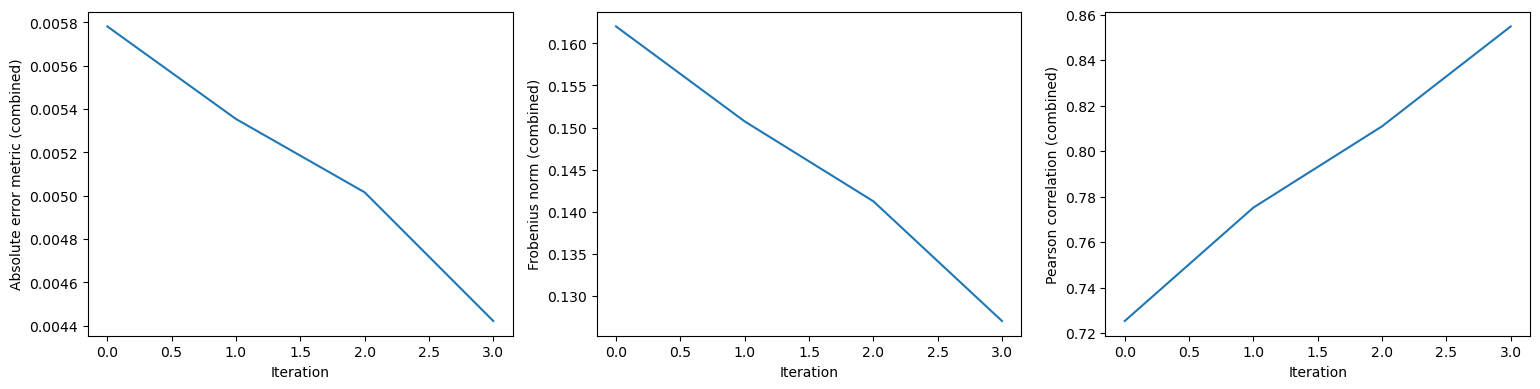

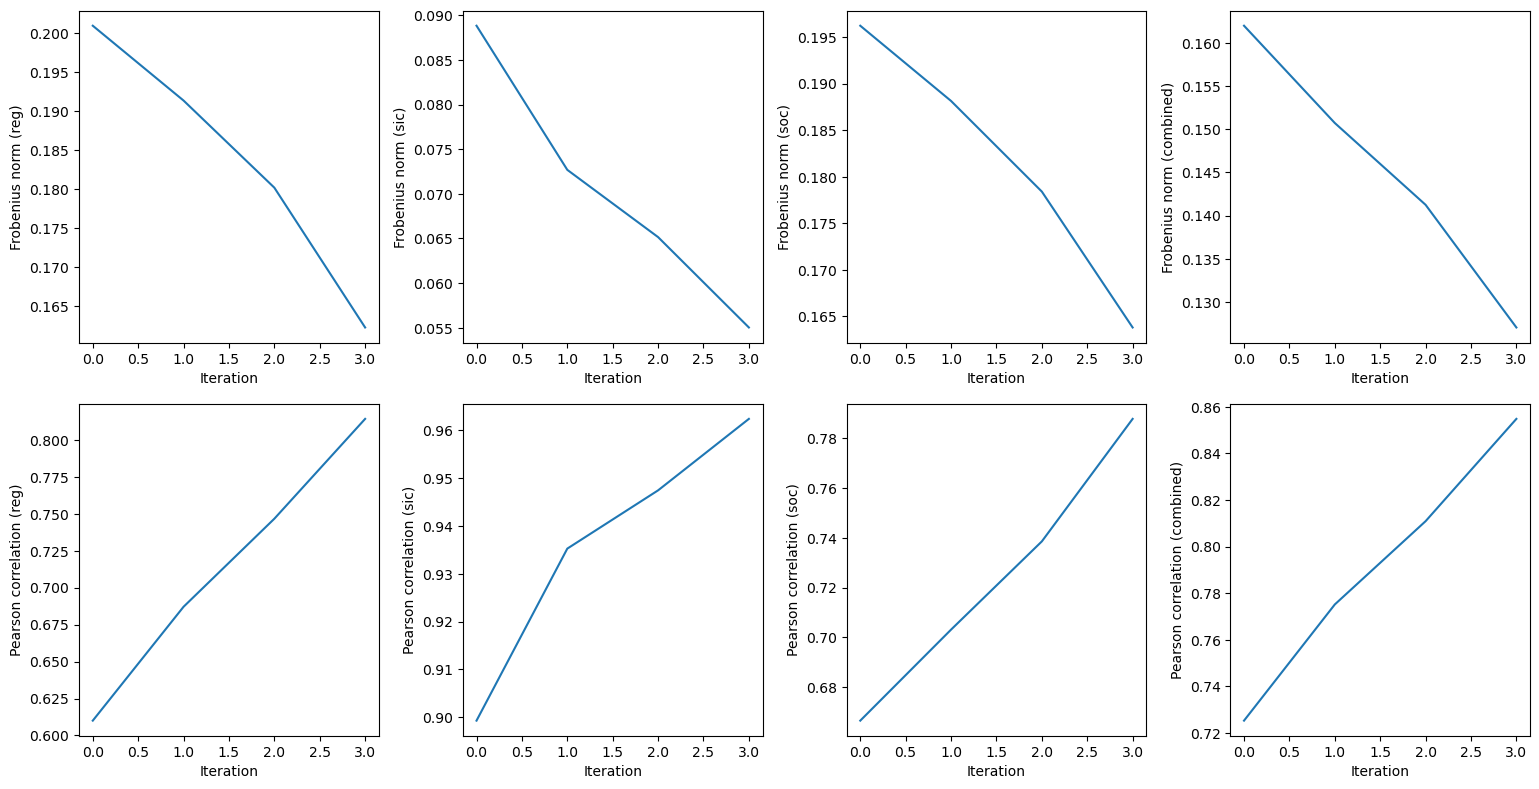

Region - frob
[0.1405404586734589]
Region - pearson
[0.8605422988822263]
Industry - frob
[0.08133403456509258]
Industry - pearson
[0.9209890605438574]
Occupation - frob
[0.1526293497785757]
Occupation - pearson
[0.8181889852130622]
Comb - frob
[0.12483461433904239]
Comb - pearson
[0.8665734482130487]
Absolute error metric: 0.004082208608052702


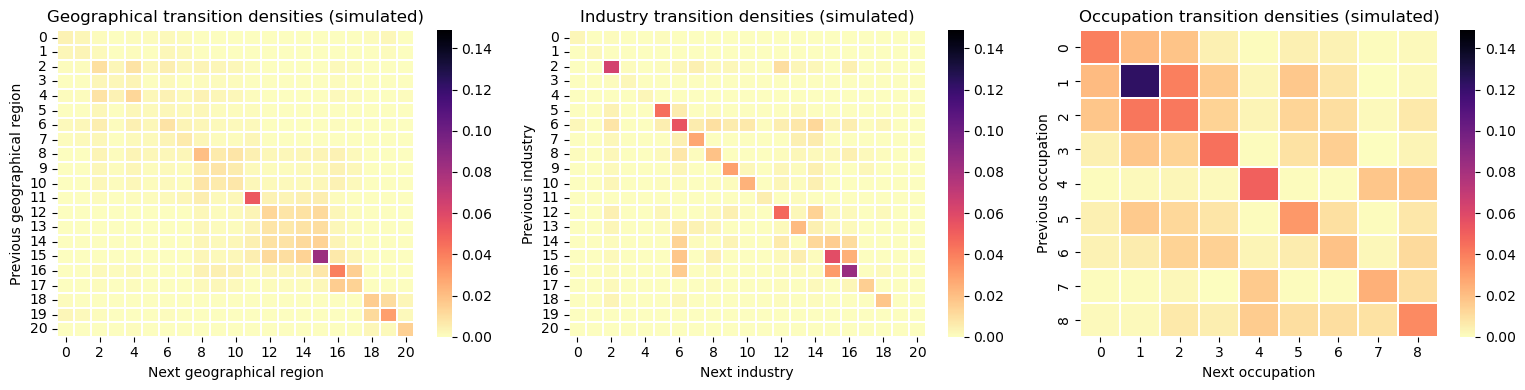

End of iteration 5


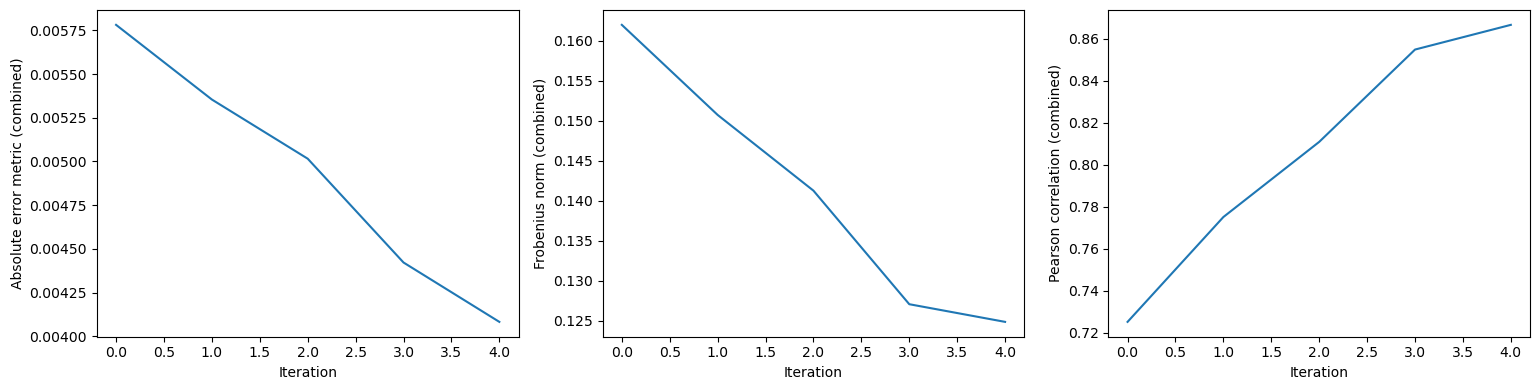

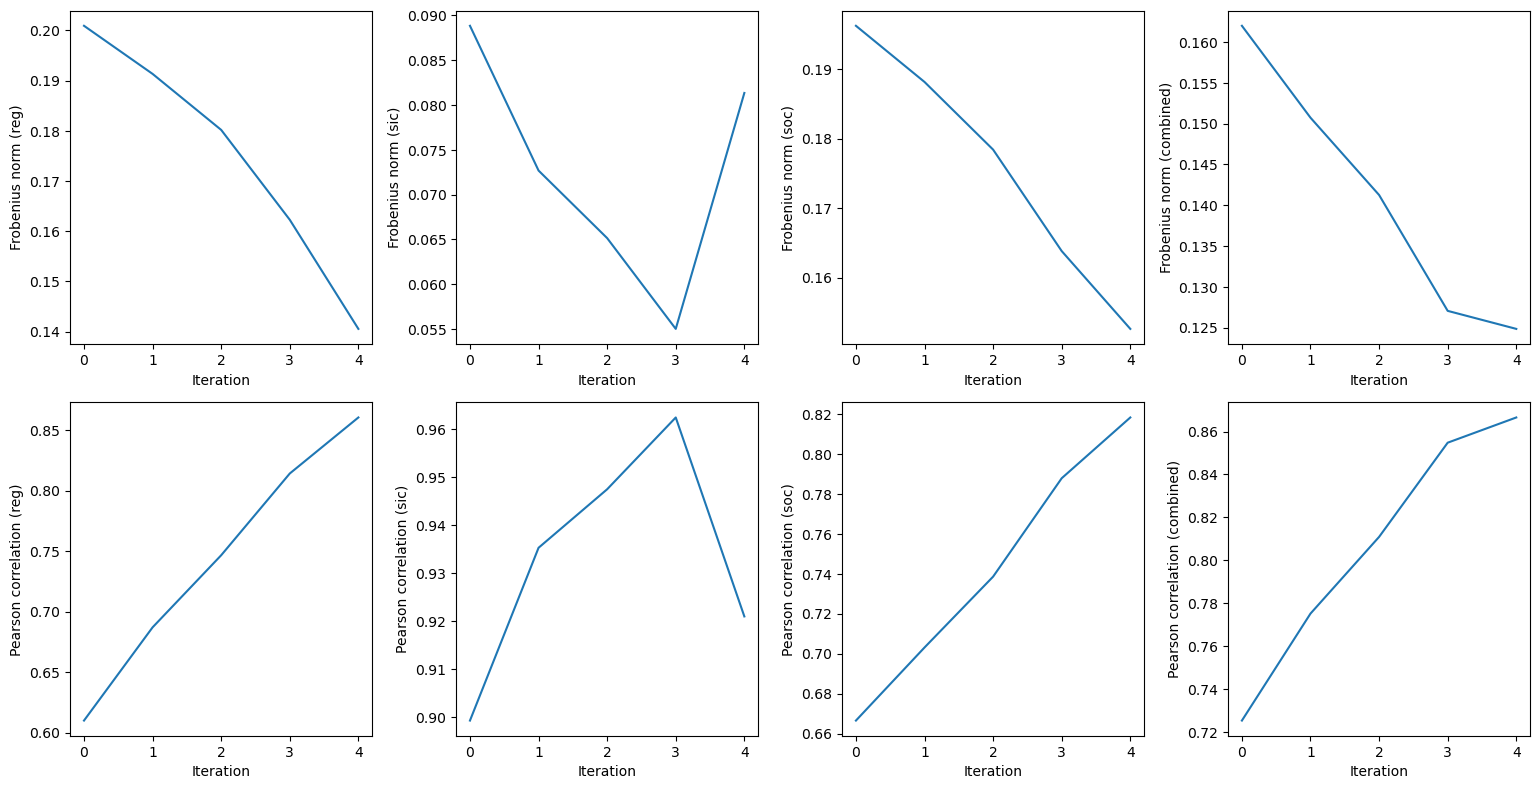

Region - frob
[0.11858010781019081]
Region - pearson
[0.8940994551093239]
Industry - frob
[0.06047373254682634]
Industry - pearson
[0.9542936697346048]
Occupation - frob
[0.13209459297398193]
Occupation - pearson
[0.8642317926223968]
Comb - frob
[0.10371614444366635]
Comb - pearson
[0.9042083058221084]
Absolute error metric: 0.0033016666806258005


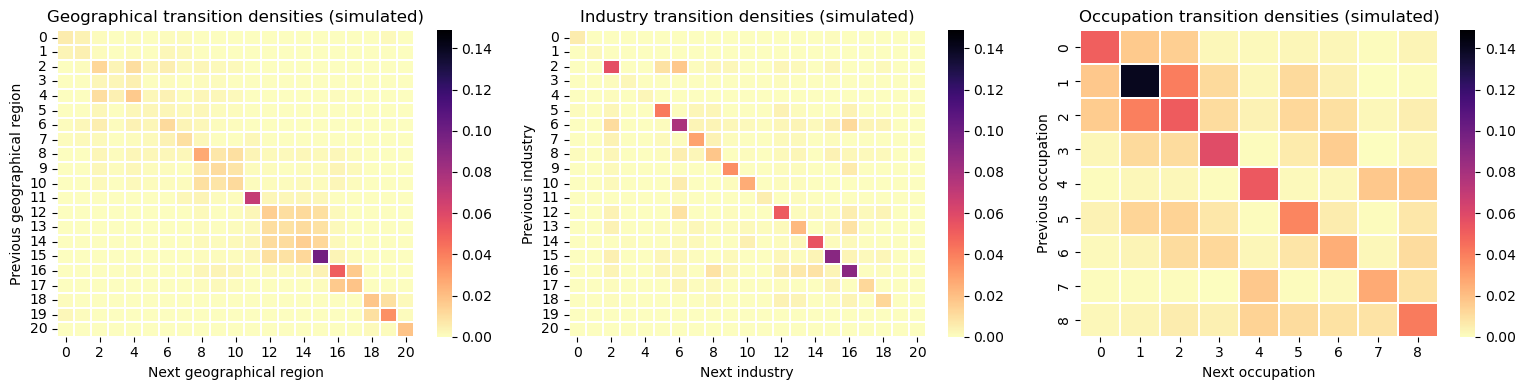

End of iteration 6


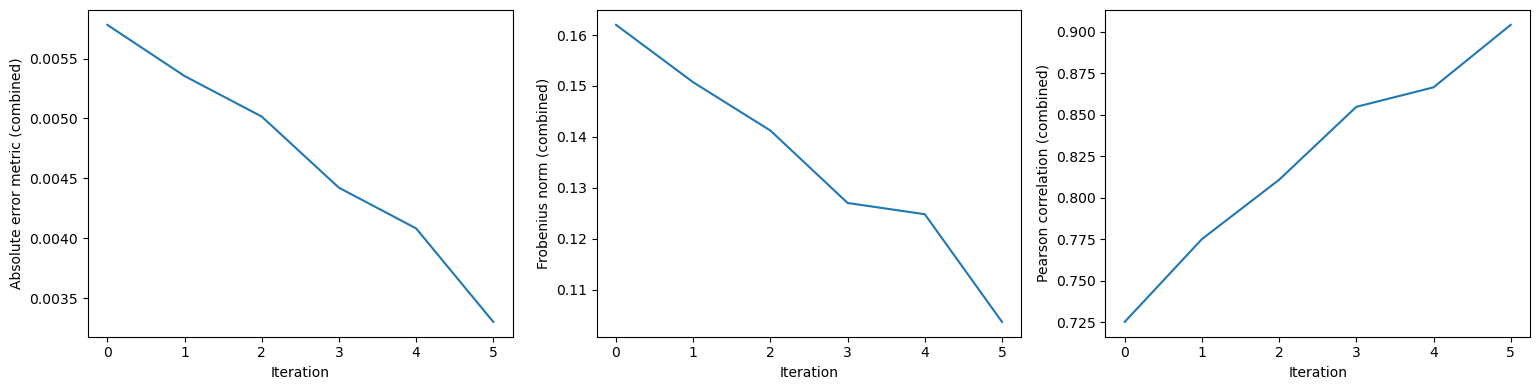

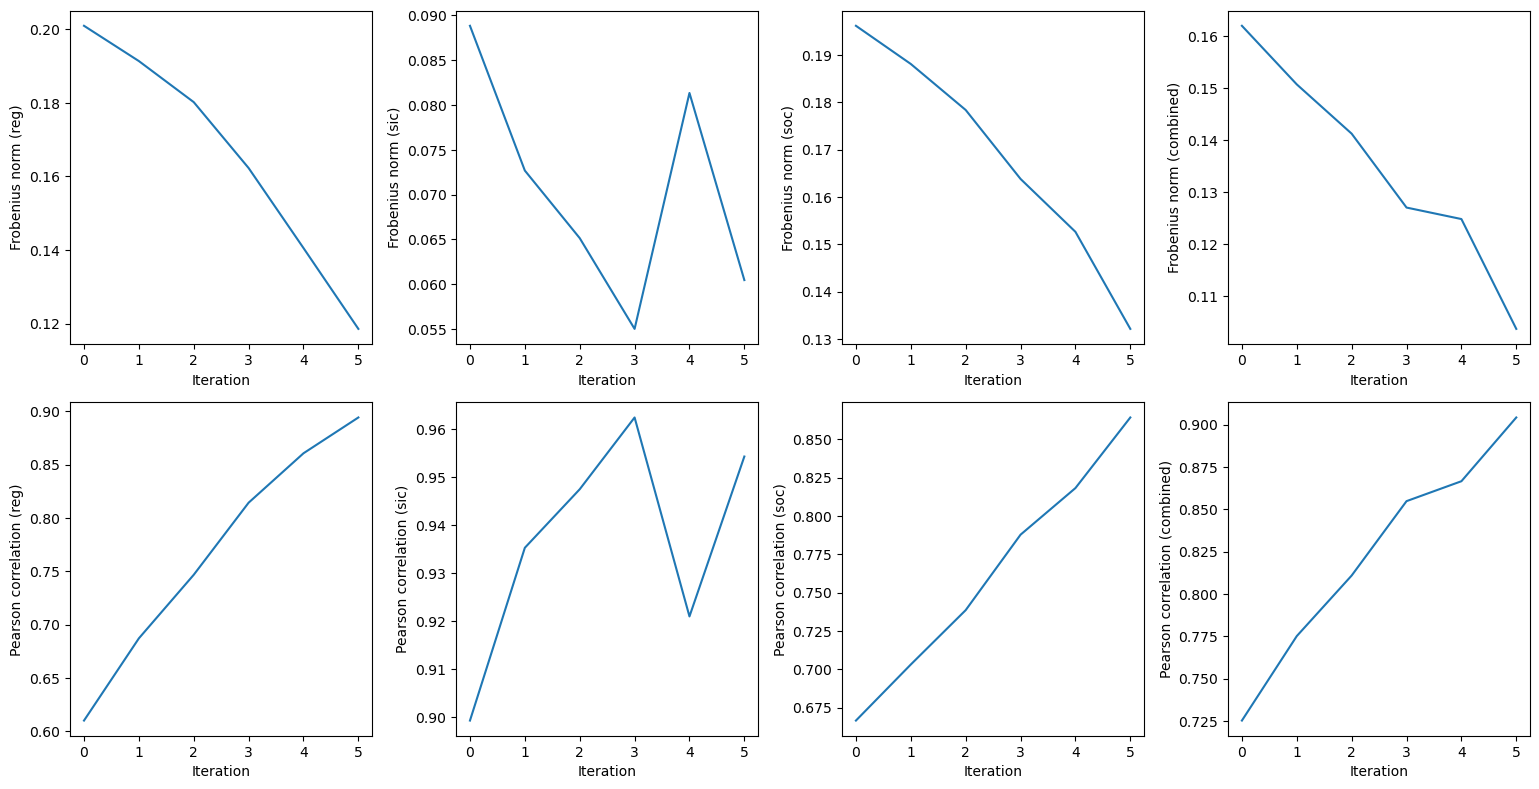

KeyboardInterrupt: 

In [6]:
# Loop for performing run(s) of the calibration algorithm
for k in range(fitrun_num):
    
    count = 0 #Initialise variable for tracking iterations needed to reach threshold
    abserr_reg = np.ones(reg_trans_mat.shape) # set to some arbitrary value greater than the threshold
    abserr_sic = np.ones(sic_trans_mat.shape) # set to some arbitrary value greater than the threshold
    abserr_soc = np.ones(soc_trans_mat.shape) # set to some arbitrary value greater than the threshold
    comb_frobenius_dif = 100 # set to some arbitrary value greater than the threshold
    comb_pearson_dif = 100 # set to some arbitrary value greater than the threshold
    
    # Initialise nu-values
    init_reg_nu_mat = np.ones(reg_trans_mat.shape)
    init_sic_nu_mat = np.ones(sic_trans_mat.shape)
    init_soc_nu_mat = np.ones(soc_trans_mat.shape)
    reg_nu_mat = init_reg_nu_mat.copy()
    sic_nu_mat = init_sic_nu_mat.copy()
    soc_nu_mat = init_soc_nu_mat.copy()
    
    node_reg_sim_mat_input = np.zeros(node_reg_sim_mat.shape)
    node_sic_sim_mat_input = np.zeros(node_sic_sim_mat.shape)
    node_soc_sim_mat_input = np.zeros(node_soc_sim_mat.shape)
    
    # Modify similarity matrices using nu values
    for i in range(0,n):
        for j in range(0,n):
            node_reg_sim_mat_input[i,j] = node_reg_sim_mat[i,j]**init_reg_nu_mat[node_dict[i][0]-1,node_dict[j][0]-1]
            node_sic_sim_mat_input[i,j] = node_sic_sim_mat[i,j]**init_sic_nu_mat[node_dict[i][1]-1,node_dict[j][1]-1]
            node_soc_sim_mat_input[i,j] = node_soc_sim_mat[i,j]**init_soc_nu_mat[node_dict[i][2]-1,node_dict[j][2]-1]
    
    input_data_dict_temp['node_reg_sim_mat'] = node_reg_sim_mat_input
    input_data_dict_temp['node_sic_sim_mat'] = node_sic_sim_mat_input
    input_data_dict_temp['node_soc_sim_mat'] = node_soc_sim_mat_input

    # Set initial value of absolute error metric
    comb_abserr_metric = 1

    # Run calibration algorithm
    while comb_abserr_metric>alg_thresh:
    
        result = Parallel(n_jobs=15)(delayed(gd_sim)(i) for i in range(sim_num))
        urates = [x[0] for x in result]
        sim_reg_tmat = [x[1] for x in result] 
        sim_sic_tmat = [x[2] for x in result] 
        sim_soc_tmat = [x[3] for x in result]
        sim_reg_tcountmat = [x[4] for x in result]
        sim_sic_tcountmat = [x[5] for x in result]
        sim_soc_tcountmat = [x[6] for x in result]
        
        # Check correlation scores
        #Compare empirical transition probability matrix with similarity matrix
        # Regions
        #Pearson correlation
        reg_pearson=(np.corrcoef(np.asarray(reg_trans_mat).flatten(),np.asarray(sim_reg_tmat).mean(axis=0).flatten()))[1,0]
        # Frobeneius norm
        reg_frobenius=(np.linalg.norm(np.asarray(reg_trans_mat).flatten()-np.asarray(sim_reg_tmat).mean(axis=0).flatten()))
        # Industries (SIC)
        #Pearson correlation
        sic_pearson=(np.corrcoef(np.asarray(sic_trans_mat).flatten(),np.asarray(sim_sic_tmat).mean(axis=0).flatten()))[1,0]
        # Frobeneius norm
        sic_frobenius=(np.linalg.norm(np.asarray(sic_trans_mat).flatten()-np.asarray(sim_sic_tmat).mean(axis=0).flatten()))
        # Occupation (SOC)
        #Pearson correlation
        soc_pearson=(np.corrcoef(np.asarray(soc_trans_mat).flatten(),np.asarray(sim_soc_tmat).mean(axis=0).flatten()))[1,0]
        # Frobeneius norm
        soc_frobenius=(np.linalg.norm(np.asarray(soc_trans_mat).flatten()-np.asarray(sim_soc_tmat).mean(axis=0).flatten()))
        #Combined (equal weighting)
        #Pearson    
        comb_pearson = 1/3*(reg_pearson+sic_pearson+soc_pearson)
        #Frobenius  
        comb_frobenius = 1/3*(reg_frobenius+sic_frobenius+soc_frobenius)
        
        # Display correlation info
        print("Region - frob")
        print([reg_frobenius])
        print("Region - pearson")
        print([reg_pearson])
        print("Industry - frob")
        print([sic_frobenius])
        print("Industry - pearson")
        print([sic_pearson])
        print("Occupation - frob")
        print([soc_frobenius])
        print("Occupation - pearson")
        print([soc_pearson])
        print("Comb - frob")
        print([comb_frobenius])
        print("Comb - pearson")
        print([comb_pearson])
        
        # Record mean error in transition matrices
        err_reg = (reg_trans_mat - sim_reg_tmat).mean(axis=0)
        abserr_reg = abs(err_reg)
        # print(np.mean(err_reg))
        err_sic = (sic_trans_mat - sim_sic_tmat).mean(axis=0)
        abserr_sic=abs(err_sic)
        # print(np.mean(err_sic))
        err_soc = (soc_trans_mat - sim_soc_tmat).mean(axis=0)
        # print(sim_soc_tmat)
        abserr_soc=abs(err_soc)
        # print(np.mean(err_soc))
        
        comb_abserr_metric = (1/3)*(np.mean(abserr_reg)+np.mean(abserr_sic)+np.mean(abserr_soc))
        print(f"Absolute error metric: {comb_abserr_metric}")
        
        #Set adjustment step size
        delta_reg = abserr_reg/(reg_trans_mat + 1e-3) 
        delta_sic = abserr_sic/(sic_trans_mat  + 1e-3)
        delta_soc = abserr_soc/(soc_trans_mat  + 1e-3)
        
        # Update nu-values
        reg_nu_mat[(err_reg<0)] = reg_nu_mat[(err_reg<0)]*np.minimum(1+abs(delta_reg[(err_reg<0)]), 3/2)
        reg_nu_mat[(err_reg>=0)] = reg_nu_mat[(err_reg>=0)]*np.maximum(1-abs(delta_reg[(err_reg>=0)]), 1/2)
        sic_nu_mat[(err_sic<0)] = sic_nu_mat[(err_sic<0)]*np.minimum(1+abs(delta_sic[(err_sic<0)]), 3/2)
        sic_nu_mat[(err_sic>=0)] = sic_nu_mat[(err_sic>=0)]*np.maximum(1-abs(delta_sic[(err_sic>=0)]), 1/2)
        soc_nu_mat[(err_soc<0)] = soc_nu_mat[(err_soc<0)]*np.minimum(1+abs(delta_soc[(err_soc<0)]), 3/2)
        soc_nu_mat[(err_soc>=0)] = soc_nu_mat[(err_soc>=0)]*np.maximum(1-abs(delta_soc[(err_soc>=0)]), 1/2)
        # Set all very large nu values to max_nu, based on the rule of thumb that since 0.001=0.999^x returns x~=6904, 
        # 7000 is a reasonable upper bound beyond which increasing the nu value won't substantially alter outcomes.
        max_nu = 7000
        reg_nu_mat[reg_nu_mat>max_nu] = max_nu
        sic_nu_mat[sic_nu_mat>max_nu] = max_nu
        soc_nu_mat[soc_nu_mat>max_nu] = max_nu
        
        node_reg_sim_mat_input = np.zeros(node_reg_sim_mat.shape)
        node_sic_sim_mat_input = np.zeros(node_sic_sim_mat.shape)
        node_soc_sim_mat_input = np.zeros(node_soc_sim_mat.shape)
        
        # Modify similarity matrices using nu values
        for i in range(0,n):
            for j in range(0,n):
                node_reg_sim_mat_input[i,j] = node_reg_sim_mat[i,j]**reg_nu_mat[node_dict[i][0]-1,node_dict[j][0]-1]
                node_sic_sim_mat_input[i,j] = node_sic_sim_mat[i,j]**sic_nu_mat[node_dict[i][1]-1,node_dict[j][1]-1]
                node_soc_sim_mat_input[i,j] = node_soc_sim_mat[i,j]**soc_nu_mat[node_dict[i][2]-1,node_dict[j][2]-1]
        
        # Update similarity matrices
        input_data_dict_temp['node_reg_sim_mat'] = node_reg_sim_mat_input
        input_data_dict_temp['node_sic_sim_mat'] = node_sic_sim_mat_input
        input_data_dict_temp['node_soc_sim_mat'] = node_soc_sim_mat_input
        
        maxval = max([reg_trans_mat.max().max(), sic_trans_mat.max().max(), soc_trans_mat.max().max(), \
                      np.array(sim_reg_tmat).mean(axis=0).max().max(), np.array(sim_sic_tmat).mean(axis=0).max().max(), \
                       np.array(sim_soc_tmat).mean(axis=0).max().max()])
        
        # Plot of job-to-job transitions
        plt.figure(1, figsize=(15.5,4))

        plt.subplot(131)
        g4=sns.heatmap(np.array(sim_reg_tmat).mean(axis=0), linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)
        g4.set_xlabel("Next geographical region")
        g4.set_ylabel("Previous geographical region")
        g4.set_title("Geographical transition densities (simulated)")

        plt.subplot(132)
        g5=sns.heatmap(np.array(sim_sic_tmat).mean(axis=0), linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)
        g5.set_xlabel("Next industry")
        g5.set_ylabel("Previous industry")
        g5.set_title("Industry transition densities (simulated)")

        plt.subplot(133)
        g6=sns.heatmap(np.array(sim_soc_tmat).mean(axis=0), linewidth=0.05, cmap="magma_r", vmin=0, vmax=maxval, cbar_ax=None)
        g6.set_xlabel("Next occupation")
        g6.set_ylabel("Previous occupation")
        g6.set_title("Occupation transition densities (simulated)")

        plt.tight_layout()
        plt.savefig(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_run{k}_nus_finalmatrix_unconditional.png', bbox_inches="tight", dpi=500)
        plt.show()

        # Store calibrated parameters and associated information from simulations
        if count==0:
        
            reg_frobenius_ts = reg_frobenius.copy()
            reg_pearson_ts = reg_pearson.copy()
            sic_frobenius_ts = sic_frobenius.copy()
            sic_pearson_ts = sic_pearson.copy()
            soc_frobenius_ts = soc_frobenius.copy()
            soc_pearson_ts = soc_pearson.copy()
            comb_frobenius_ts = comb_frobenius.copy()
            comb_pearson_ts = comb_pearson.copy()
            comb_abserr_metric_ts=comb_abserr_metric.copy()
            sim_reg_tmat_ts = np.dstack((sim_reg_tmat)).copy()
            sim_sic_tmat_ts = np.dstack((sim_sic_tmat)).copy()
            sim_soc_tmat_ts = np.dstack((sim_soc_tmat)).copy()
            
        else:
            
            reg_frobenius_ts = np.vstack((reg_frobenius_ts,reg_frobenius)).copy()
            reg_pearson_ts = np.vstack((reg_pearson_ts,reg_pearson)).copy()
            sic_frobenius_ts = np.vstack((sic_frobenius_ts,sic_frobenius)).copy()
            sic_pearson_ts = np.vstack((sic_pearson_ts,sic_pearson)).copy()
            soc_frobenius_ts = np.vstack((soc_frobenius_ts,soc_frobenius)).copy()
            soc_pearson_ts = np.vstack((soc_pearson_ts,soc_pearson)).copy()
            comb_frobenius_ts = np.vstack((comb_frobenius_ts,comb_frobenius)).copy()
            comb_pearson_ts = np.vstack((comb_pearson_ts,comb_pearson)).copy()
            comb_abserr_metric_ts = np.vstack((comb_abserr_metric_ts,comb_abserr_metric))
            
            if count > 1:
                sim_reg_tmat_ts = np.append(sim_reg_tmat_ts, np.expand_dims(np.dstack((sim_reg_tmat)), axis=-1), axis=-1)
                sim_sic_tmat_ts = np.append(sim_sic_tmat_ts, np.expand_dims(np.dstack((sim_sic_tmat)), axis=-1), axis=-1)
                sim_soc_tmat_ts = np.append(sim_soc_tmat_ts, np.expand_dims(np.dstack((sim_soc_tmat)), axis=-1), axis=-1)
            
            else:
                sim_reg_tmat_ts = np.stack((sim_reg_tmat_ts, np.dstack((sim_reg_tmat))), axis=-1)
                sim_sic_tmat_ts = np.stack((sim_sic_tmat_ts, np.dstack((sim_sic_tmat))), axis=-1)
                sim_soc_tmat_ts = np.stack((sim_soc_tmat_ts, np.dstack((sim_soc_tmat))), axis=-1)

        count += 1
        print(f"End of iteration {count}")
        
        if count > 2:
        
            # Figures showing metrics from simulations
            
            # Show metrics aggregated across all 3 LFNs
            plt.figure(0, figsize=(15.5,4))
     
            plt.subplot(131)
            plt.plot(comb_abserr_metric_ts)
            plt.ylabel("Absolute error metric (combined)")
            plt.xlabel("Iteration")
     
            plt.subplot(132)
            plt.plot(comb_frobenius_ts)
            plt.ylabel("Frobenius norm (combined)")
            plt.xlabel("Iteration")
     
            plt.subplot(133)
            plt.plot(comb_pearson_ts)
            plt.ylabel("Pearson correlation (combined)")
            plt.xlabel("Iteration")
            
            plt.tight_layout()
            plt.savefig(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_run{k}_LFS_combinedmetrics.png', bbox_inches="tight", dpi=500)
            plt.show() 
            
        
            # Show metrics for each LFN
            plt.figure(2, figsize=(15.5,8))
    
            plt.subplot(241)
            plt.plot(reg_frobenius_ts)
            plt.ylabel("Frobenius norm (reg)")
            plt.xlabel("Iteration")
    
            plt.subplot(242)
            plt.plot(sic_frobenius_ts)
            plt.ylabel("Frobenius norm (sic)")
            plt.xlabel("Iteration")
    
            plt.subplot(243)
            plt.plot(soc_frobenius_ts)
            plt.ylabel("Frobenius norm (soc)")
            plt.xlabel("Iteration")
    
            plt.subplot(244)
            plt.plot(comb_frobenius_ts)
            plt.ylabel("Frobenius norm (combined)")
            plt.xlabel("Iteration")
    
            plt.subplot(245)
            plt.plot(reg_pearson_ts)
            plt.ylabel("Pearson correlation (reg)")
            plt.xlabel("Iteration")
    
            plt.subplot(246)
            plt.plot(sic_pearson_ts)
            plt.ylabel("Pearson correlation (sic)")
            plt.xlabel("Iteration")
    
            plt.subplot(247)
            plt.plot(soc_pearson_ts)
            plt.ylabel("Pearson correlation (soc)")
            plt.xlabel("Iteration")
    
            plt.subplot(248)
            plt.plot(comb_pearson_ts)
            plt.ylabel("Pearson correlation (combined)")
            plt.xlabel("Iteration")
    
            plt.tight_layout()
            plt.savefig(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_run{k}_LFS_pearsonfrob.png', bbox_inches="tight", dpi=500)
            plt.show()    
        
        if count == 20: # NB: currently have a set break after 20 iterations of the fitting algorithm, based on current parametrisation of model, however can remove and run until while condition is met if starting fresh
            
            pickle.dump(sim_reg_tmat_ts, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_run{k}_reg_tmat_LFS.sav', 'wb'))
            pickle.dump(sim_sic_tmat_ts, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_run{k}_sic_tmat_LFS.sav', 'wb'))
            pickle.dump(sim_soc_tmat_ts, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_run{k}_soc_tmat_LFS.sav', 'wb'))

            break
    
    # Store calibrated parameters
    if k==0:
        
        reg_nu_mat_store = reg_nu_mat.copy()
        sic_nu_mat_store = sic_nu_mat.copy()
        soc_nu_mat_store = soc_nu_mat.copy()
        reg_frobenius_ts = np.concatenate([reg_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        reg_frobenius_store = reg_frobenius_ts.copy()
        reg_pearson_ts = np.concatenate([reg_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        reg_pearson_store = reg_pearson_ts.copy()
        sic_frobenius_ts = np.concatenate([sic_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        sic_frobenius_store = sic_frobenius_ts.copy()
        sic_pearson_ts = np.concatenate([sic_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        sic_pearson_store = sic_pearson_ts.copy()
        soc_frobenius_ts = np.concatenate([soc_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        soc_frobenius_store = soc_frobenius_ts.copy()
        soc_pearson_ts = np.concatenate([soc_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        soc_pearson_store = soc_pearson_ts.copy()
        comb_frobenius_ts = np.concatenate([comb_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        comb_frobenius_store = comb_frobenius_ts.copy()
        comb_pearson_ts = np.concatenate([comb_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        comb_pearson_store = comb_pearson_ts.copy()
        comb_abserr_metric_ts = np.concatenate([comb_abserr_metric_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        comb_abserr_metric_store = comb_abserr_metric_ts.copy()

    else:
        
        reg_nu_mat_store = np.dstack((reg_nu_mat_store,reg_nu_mat)).copy()
        sic_nu_mat_store = np.dstack((sic_nu_mat_store,sic_nu_mat)).copy()
        soc_nu_mat_store = np.dstack((soc_nu_mat_store,soc_nu_mat)).copy()
        reg_frobenius_ts = np.concatenate([reg_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        reg_frobenius_store = np.vstack((reg_frobenius_store,reg_frobenius_ts)).copy()
        reg_pearson_ts = np.concatenate([reg_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        reg_pearson_store = np.vstack((reg_pearson_store,reg_pearson_ts)).copy()
        sic_frobenius_ts = np.concatenate([sic_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        sic_frobenius_store = np.vstack((sic_frobenius_store,sic_frobenius_ts)).copy()
        sic_pearson_ts = np.concatenate([sic_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        sic_pearson_store = np.vstack((sic_pearson_store,sic_pearson_ts)).copy()
        soc_frobenius_ts = np.concatenate([soc_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        soc_frobenius_store = np.vstack((soc_frobenius_store,soc_frobenius_ts)).copy()
        soc_pearson_ts = np.concatenate([soc_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        soc_pearson_store = np.vstack((soc_pearson_store,soc_pearson_ts)).copy()
        comb_frobenius_ts = np.concatenate([comb_frobenius_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        comb_frobenius_store = np.vstack((comb_frobenius_store,comb_frobenius_ts)).copy()
        comb_pearson_ts = np.concatenate([comb_pearson_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        comb_pearson_store = np.vstack((comb_pearson_store,comb_pearson_ts)).copy()
        comb_abserr_metric_ts = np.concatenate([comb_abserr_metric_ts, np.array(range(1,count+1))[...,None], (k+1)*np.ones([count,1])], 1)
        comb_abserr_metric_store = np.vstack((comb_abserr_metric_store,comb_abserr_metric_ts)).copy()
    

    
    print(f"Completion percentage: {100*((k+1)/fitrun_num)}")

## Save calibration results

In [ ]:
# Save calibration output
pickle.dump(reg_nu_mat_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_nus_reg_scost_mat_LFS.sav', 'wb'))
pickle.dump(sic_nu_mat_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_nus_sic_scost_mat_LFS.sav', 'wb'))
pickle.dump(soc_nu_mat_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_nus_soc_scost_mat_LFS.sav', 'wb'))

pickle.dump(reg_frobenius_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_reg_frobenius_LFS.sav', 'wb'))
pickle.dump(reg_pearson_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_reg_pearson_LFS.sav', 'wb'))
pickle.dump(sic_frobenius_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_sic_frobenius_LFS.sav', 'wb'))
pickle.dump(sic_pearson_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_sic_pearson_LFS.sav', 'wb'))
pickle.dump(soc_frobenius_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_soc_frobenius_LFS.sav', 'wb'))
pickle.dump(soc_pearson_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_soc_pearson_LFS.sav', 'wb'))
pickle.dump(comb_frobenius_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_comb_frobenius_LFS.sav', 'wb'))
pickle.dump(comb_pearson_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_comb_pearson_LFS.sav', 'wb'))
pickle.dump(comb_abserr_metric_store, open(f'{home}data/calibration/graddescent_N{N}_reps{sim_num}_GDruns{fitrun_num}_ssthresh{ss_threshold}_comb_abserr_metric_LFS.sav', 'wb'))